In [1]:
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install umap-learn
import umap.umap_ as umap
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=3ac9b519e80c7b82f00b2e0e6e50da65a91313c204cab8c1dca81312fca9d716
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
data = pd.read_csv('/content/drive/MyDrive/bot.csv')

<ipython-input-55-42e96b9528c2>:1: DtypeWarning: Columns (8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/bot.csv')


In [56]:
data.drop(columns=['subcategory','pkSeqID','stime','flgs','attack','state','proto','seq'],inplace=True)

In [57]:
data.rename(columns={"category": "label"},inplace = True)

In [58]:
data.label.value_counts()

DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: label, dtype: int64

In [59]:
DDoS = data[data['label'] == 'DDoS'].sample(frac=0.1)
DoS = data[data['label'] == 'DoS'].sample(frac=0.1)
Reconnaissance = data[data['label'] == 'Reconnaissance'].sample(frac=0.1)
Normal = data[data['label'] == 'Normal']
Theft = data[data['label'] == 'Theft']

In [60]:
data = pd.concat([DDoS,DoS,Reconnaissance,Normal,Theft])

In [61]:
data.label.value_counts()

DDoS              192662
DoS               165026
Reconnaissance      9108
Normal               477
Theft                 79
Name: label, dtype: int64

In [62]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [63]:
data['saddr'] = data.saddr.apply(str)
data['sport'] = data.sport.apply(str)
data['daddr'] = data.daddr.apply(str)
data['dport'] = data.dport.apply(str)

In [64]:
data['saddr'] = data.saddr.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [65]:
data['saddr'] = data['saddr'] + ':' + data['sport']
data['daddr'] = data['daddr'] + ':' + data['dport']

In [66]:
data.drop(columns=['sport','dport'],inplace=True)
label_ground_truth = data[["saddr", "daddr","label"]]
data = pd.get_dummies(data, columns = ['flgs_number','state_number', 'proto_number'])

In [67]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [68]:
data.fillna(0,inplace = True)

In [69]:
label_ground_truth = data[["saddr", "daddr","label"]]

In [70]:
data.drop(columns=['index'],inplace=True)
data.drop(columns=['Unnamed: 0'],inplace=True)
data.drop(columns=['state_number_11'],inplace=True)

In [71]:
data
# print(data.columns)

,saddr,daddr,pkts,bytes,ltime,dur,mean,stddev,sum,min,...,state_number_6,state_number_7,state_number_8,state_number_9,state_number_10,proto_number_1,proto_number_2,proto_number_3,proto_number_4,proto_number_5
0,172.25.166.127:39634,192.168.100.3:80,5,770,1.528096e+09,12.580473,2.147057,1.521483,6.441171,0.000000,...,0,0,0,0,0,1,0,0,0,0
1,172.24.61.32:7917,192.168.100.3:80,6,360,1.528099e+09,10.351658,4.130036,0.068667,8.260073,4.061369,...,0,0,0,0,0,0,0,1,0,0
2,172.27.230.134:26788,192.168.100.3:80,15,900,1.528099e+09,13.660125,3.910331,1.368609,11.730991,1.974834,...,0,0,0,0,0,0,0,1,0,0
3,172.26.91.20:31427,192.168.100.3:80,2,308,1.528096e+09,10.117023,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
4,172.24.232.237:28205,192.168.100.3:80,8,1044,1.528096e+09,16.993950,2.637203,1.524107,10.548814,0.000000,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367347,172.27.236.39:35064,192.168.100.3:22,6,434,1.529381e+09,0.013165,0.013165,0.000000,0.013165,0.013165,...,0,0,0,0,0,1,0,0,0,0
367348,172.27.169.222:35066,192.168.100.3:22,6,434,1.529381e+09,0.000574,0.000574,0.000000,0.000574,0.000574,...,0,0,0,0,0,1,0,0,0,0
367349,172.23.106.74:35070,192.168.100.3:22,31,5472,1.529381e+09,2.874302,2.874302,0.000000,2.874302,2.874302,...,1,0,0,0,0,1,0,0,0,0
367350,172.21.174.159:43001,192.168.100.150:4433,2,134,1.529381e+09,0.000003,0.000003,0.000000,0.000003,0.000003,...,0,0,0,0,0,1,0,0,0,0


In [72]:
scaler = StandardScaler()
cols_to_norm = list(set(list(data.iloc[:, 2:].columns ))  - set(list(['label'])) )
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label_ground_truth, test_size=0.3, random_state=42, stratify=label_ground_truth.label)

In [74]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()


In [75]:
#from dgl.data.utils import load_graphs
#G = load_graphs("./data.bin")[0][0]

In [76]:
G = nx.from_pandas_edgelist(X_train, "saddr", "daddr", ['h','label'], create_using= nx.MultiGraph())

In [77]:
G = G.to_directed()

In [78]:
G = from_networkx(G,edge_attrs=['h','label'])

In [79]:
#from dgl.data.utils import save_graphs
#save_graphs("./data.bin", [G])


In [80]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [81]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype= th.bool)

In [82]:
#G = load_graphs("./bot_train_G.bin") [0][0]

In [83]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [84]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [85]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, G.edata['h'].shape[1]))

In [86]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        global score
        global emb
        emb = th.cat([h_u, h_v], 1)
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [87]:
G.ndata['h'].shape

torch.Size([261192, 1, 52])

In [88]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [89]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [90]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 5)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [91]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(G.edata['label'].cpu().numpy()),
                                                 y = G.edata['label'].cpu().numpy())

In [92]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [93]:
G = G.to('cuda:0')

In [94]:
G.device

device(type='cuda', index=0)

In [95]:
G.ndata['h'].device

device(type='cuda', index=0)

In [96]:
G.edata['h'].device

device(type='cuda', index=0)

In [97]:
criterion = nn.CrossEntropyLoss()

In [98]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()

opt = th.optim.Adam(model.parameters())

for epoch in range(1,7500):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Epoch: 100  Training acc: 0.922798752784729
Epoch: 200  Training acc: 0.981452226638794
Epoch: 300  Training acc: 0.9879485368728638
Epoch: 400  Training acc: 0.9891482591629028
Epoch: 500  Training acc: 0.9944953918457031
Epoch: 600  Training acc: 0.9944565296173096
Epoch: 700  Training acc: 0.9972428679466248
Epoch: 800  Training acc: 0.9968928694725037
Epoch: 900  Training acc: 0.9956037402153015
Epoch: 1000  Training acc: 0.9981120228767395
Epoch: 1100  Training acc: 0.9978281259536743
Epoch: 1200  Training acc: 0.9983122944831848
Epoch: 1300  Training acc: 0.9980225563049316
Epoch: 1400  Training acc: 0.9961597919464111
Epoch: 1500  Training acc: 0.9984289407730103
Epoch: 1600  Training acc: 0.9990084171295166
Epoch: 1700  Training acc: 0.9991172552108765
Epoch: 1800  Training acc: 0.9993758797645569
Epoch: 1900  Training acc: 0.9993428587913513
Epoch: 2000  Training acc: 0.999416708946228
Epoch: 2100  Training acc: 0.99941086769104
Epoch: 2200  Training acc: 0.999552845954895
Epo

In [99]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [100]:
#G_test = load_graphs("bot_test_G.bin") [0][0]
G_test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')


In [101]:
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), 52) # Earlier here was 52

In [102]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [103]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [104]:
G_test = G_test.to('cuda:0')

In [105]:
th.cuda.empty_cache()

In [106]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [107]:
print(str(elapsed) + ' seconds')

0.14508799400027783 seconds


In [108]:
test_pred = test_pred.argmax(1)

In [109]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [110]:
edge_label = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [111]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

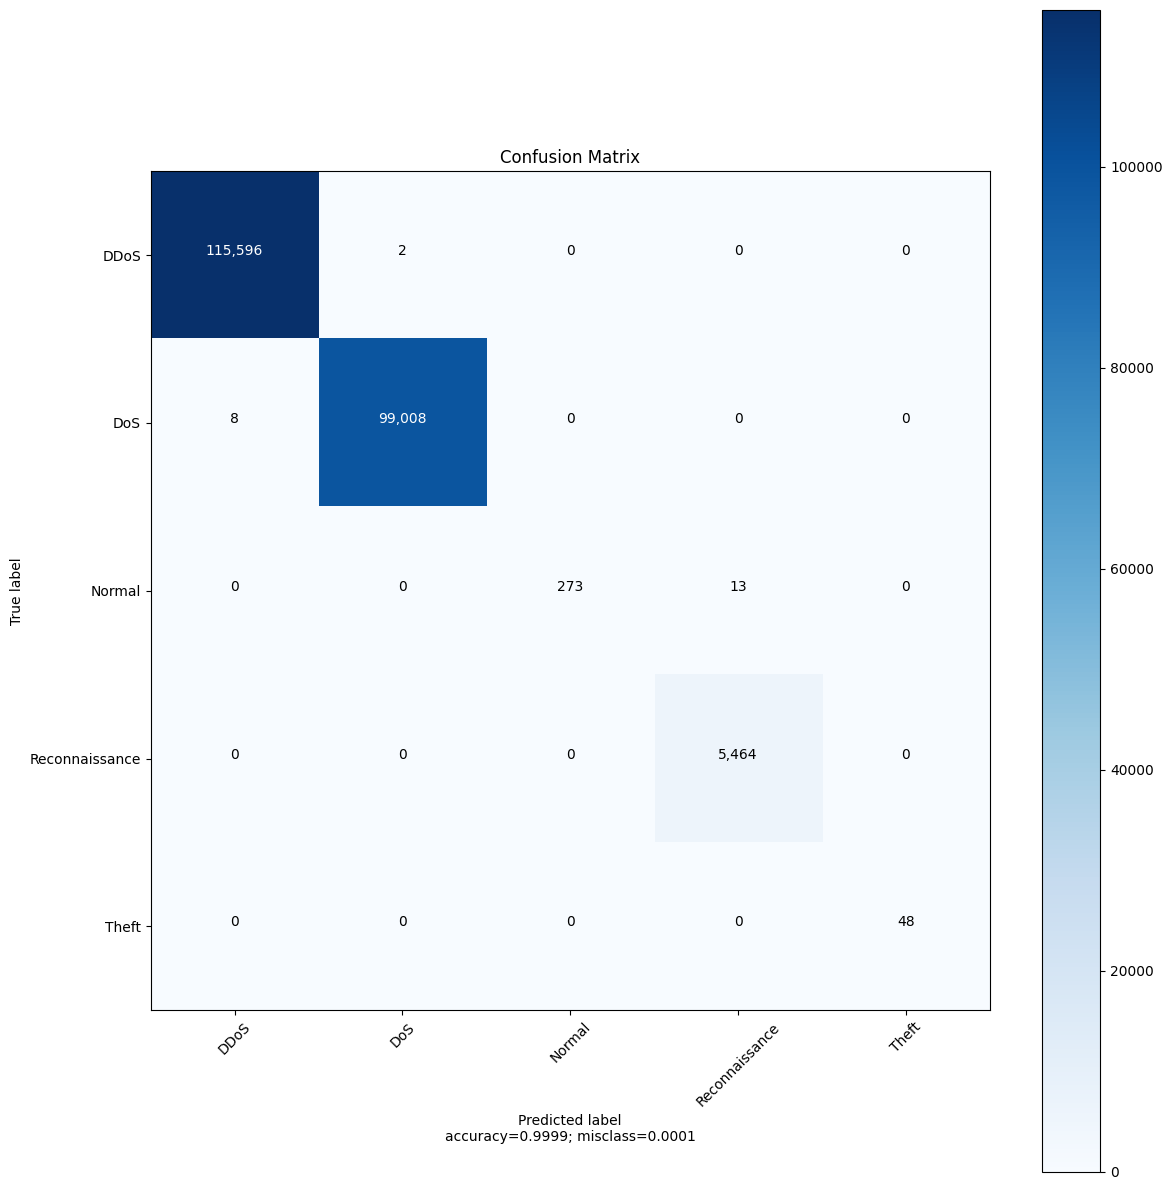

In [112]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(edge_label, test_pred),
                      normalize    = False,
                      target_names = np.unique(edge_label),
                      title        = "Confusion Matrix")

In [113]:
from sklearn.metrics import classification_report
target_names = np.unique(edge_label)
print(classification_report(edge_label, test_pred, target_names=target_names, digits=4))

                precision    recall  f1-score   support

          DDoS     0.9999    1.0000    1.0000    115598
           DoS     1.0000    0.9999    0.9999     99016
        Normal     1.0000    0.9545    0.9767       286
Reconnaissance     0.9976    1.0000    0.9988      5464
         Theft     1.0000    1.0000    1.0000        48

      accuracy                         0.9999    220412
     macro avg     0.9995    0.9909    0.9951    220412
  weighted avg     0.9999    0.9999    0.9999    220412



In [114]:
emb_num = emb.cpu().detach().numpy()
print(emb.shape)

torch.Size([220412, 256])


In [115]:
np.save('emb_mul.npy',emb_num)

In [116]:

# Initialize UMAP model
umap_model = umap.UMAP(n_components=2)  # You can adjust the number of components as needed

# Fit the UMAP model to your embeddings
emb_viz = umap_model.fit_transform(emb_num)

# Now 'emb_viz' contains the 2D representation of your embeddings
# You can use 'emb_viz' for visualization or further analysis

# Save the UMAP visualization data
np.save('emb_viz.npy', emb_viz)


In [117]:
emb_viz = np.load('emb_viz.npy')
print(emb_viz.shape)

(220412, 2)


In [131]:
df_umap = pd.DataFrame(emb_viz, columns=['comp1', 'comp2'])


In [132]:
df_umap['label'] = edge_label


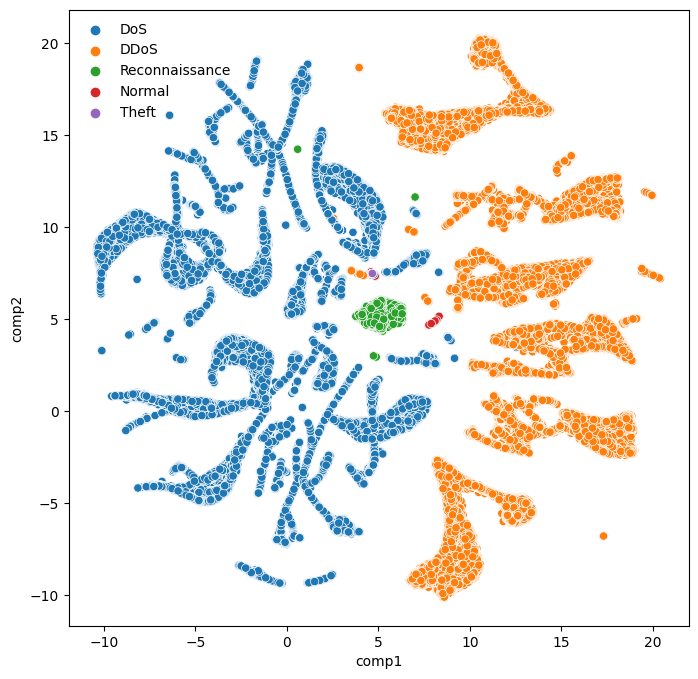

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8));
df_umap = df_umap.sample(frac=1)
# print(df_umap.type)
sns.scatterplot(x='comp1', y='comp2', data=df_umap, hue='label');
plt.legend(loc='upper left', frameon=False)

In [121]:
emb_num = score.cpu().detach().numpy()

In [122]:
np.save('emb_mul.npy',emb_num)

In [123]:
emb_viz = np.load('emb_viz.npy')
df_umap = pd.DataFrame(emb_viz, columns=['comp1', 'comp2'])
df_umap['label'] = edge_label


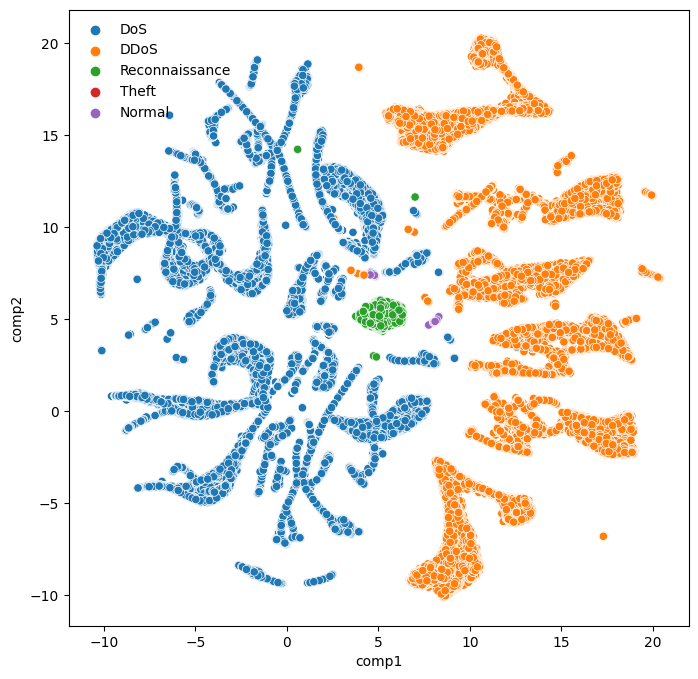

In [140]:
plt.figure(figsize=(8,8));
df_umap = df_umap.sample(frac=1)

sns.scatterplot(x='comp1', y='comp2', data=df_umap, hue='label');
plt.legend(loc='upper left', frameon=False)

In [125]:
raw1 = X_test.drop(columns=['saddr','daddr','h']).to_numpy()
raw = umap_model.fit_transform(raw1)

np.save('raw.npy',raw)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [126]:
raw_viz = np.load('raw.npy')

In [127]:
df_umap = pd.DataFrame(raw_viz, columns=['comp1', 'comp2'])

In [128]:
df_umap['label'] = le.inverse_transform(y_test.label)

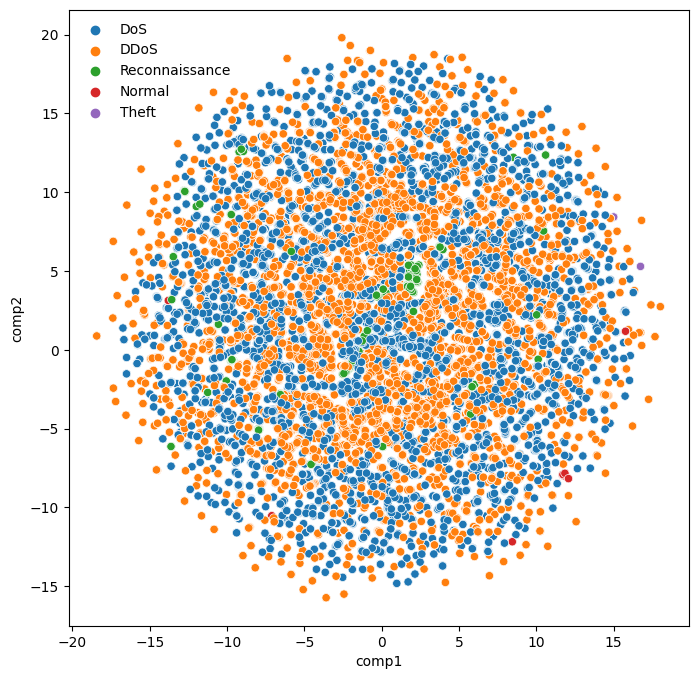

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8));
sns.scatterplot(x='comp1', y='comp2', data=df_umap, hue='label');
plt.legend(loc='upper left', frameon=False)